In [1]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv

--2025-10-08 14:55:19--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 874188 (854K) [text/plain]
Saving to: ‘car_fuel_efficiency.csv’

car_fuel_efficiency 100%[===================>] 853.70K  --.-KB/s    in 0.009s  

2025-10-08 14:55:19 (92.0 MB/s) - ‘car_fuel_efficiency.csv’ saved [874188/874188]



In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("car_fuel_efficiency.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9704 entries, 0 to 9703
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   engine_displacement  9704 non-null   int64  
 1   num_cylinders        9222 non-null   float64
 2   horsepower           8996 non-null   float64
 3   vehicle_weight       9704 non-null   float64
 4   acceleration         8774 non-null   float64
 5   model_year           9704 non-null   int64  
 6   origin               9704 non-null   object 
 7   fuel_type            9704 non-null   object 
 8   drivetrain           9704 non-null   object 
 9   num_doors            9202 non-null   float64
 10  fuel_efficiency_mpg  9704 non-null   float64
dtypes: float64(6), int64(2), object(3)
memory usage: 834.1+ KB


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

<Axes: xlabel='fuel_efficiency_mpg', ylabel='Count'>

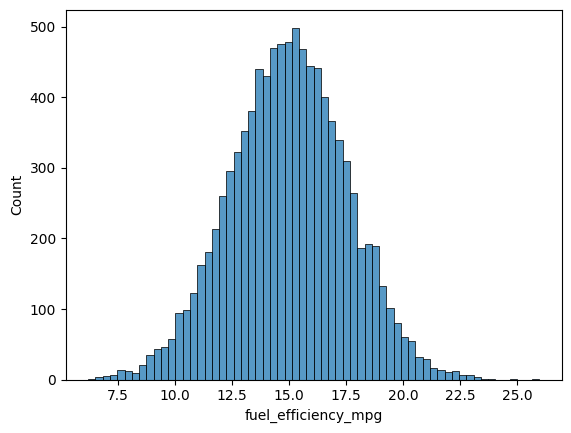

In [5]:
sns.histplot(df["fuel_efficiency_mpg"])

## Question 1

In [6]:
features = [
    "engine_displacement",
    "horsepower",
    "vehicle_weight",
    "model_year",
]

target = "fuel_efficiency_mpg"

In [7]:
df[features].isna().sum()

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
dtype: int64

## Question 2

In [8]:
print(f"Median horsepower = {df["horsepower"].median()}")

Median horsepower = 149.0


In [9]:
n = len(df)
n

9704

In [10]:
idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)

In [11]:
idx

array([ 483, 7506, 8795, ..., 5390,  860, 7270], shape=(9704,))

In [12]:
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

In [13]:
def prepare_and_split_dataset(df):
    df = df[[*features, target]].copy()
    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train:n_train+n_val]]
    df_test = df.iloc[idx[n_train+n_val:]]
    y_train = df_train[target].copy()
    y_val = df_val[target].copy()
    y_test = df_test[target].copy()
    return df_train[features], df_val[features], df_test[features], y_train, y_val, y_test

In [14]:
df_train, df_val, df_test, y_train, y_val, y_test = prepare_and_split_dataset(df)

In [15]:
len(df_train) + len(df_val) + len(df_test), len(df)

(9704, 9704)

## Question 3

In [16]:
def train_linear_regression(X, y):
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    return w

In [17]:
def compute_rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

### Option 1: fill missing horsepower values with 0

In [18]:
def prepare_X_option_1(df):
    df["horsepower"] = df["horsepower"].fillna(0)
    X = df.values
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    return X

In [19]:
X_train = prepare_X_option_1(df_train)
w = train_linear_regression(X_train, y_train)

X_val = prepare_X_option_1(df_val)
y_pred = X_val.dot(w)
round(compute_rmse(y_val, y_pred), 2)

np.float64(0.52)

### Option 2: fill missing horsepower values with mean

In [20]:
def prepare_X_option_2(df):
    df["horsepower"] = df["horsepower"].fillna(df["horsepower"].mean())
    X = df.values
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    return X

In [21]:
X_train = prepare_X_option_2(df_train)
w = train_linear_regression(X_train, y_train)

X_val = prepare_X_option_2(df_val)
y_pred = X_val.dot(w)
round(compute_rmse(y_val, y_pred), 2)

np.float64(0.52)

## Question 4

In [22]:
def train_linear_regression_reg(X, y, r=0.01):
    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    return w

In [23]:
X_train = prepare_X_option_1(df_train)
for r in [0, 0.01, 1, 10, 100]:
    w = train_linear_regression_reg(X_train, y_train, r)
    X_val = prepare_X_option_1(df_val)
    y_pred = X_val.dot(w)
    print(f"RMSE, r = {r}: {round(compute_rmse(y_val, y_pred), 2)}")

RMSE, r = 0: 0.52
RMSE, r = 0.01: 0.52
RMSE, r = 1: 0.52
RMSE, r = 10: 0.52
RMSE, r = 100: 0.52


## Question 5

In [24]:
seed_scores = {}
for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    idx = np.arange(n)
    np.random.seed(seed)
    np.random.shuffle(idx)
    df_train, df_val, df_test, y_train, y_val, y_test = prepare_and_split_dataset(df)

    X_train = prepare_X_option_1(df_train)
    w = train_linear_regression(X_train, y_train)
    
    X_val = prepare_X_option_1(df_val)
    y_pred = X_val.dot(w)
    seed_scores[seed] = compute_rmse(y_val, y_pred)

std = np.std(list(seed_scores.values()))
print(f"std seed scores = {round(std, 3)}")

std seed scores = 0.007


## Question 6

In [25]:
idx = np.arange(n)
np.random.seed(9)
np.random.shuffle(idx)
df_train, df_val, df_test, y_train, y_val, y_test = prepare_and_split_dataset(df)
df_full = pd.concat([df_train, df_val])
y_full = np.concatenate([y_train, y_val])

X_full = prepare_X_option_1(df_full)
w = train_linear_regression_reg(X_full, y_full, r=0.001)

X_test = prepare_X_option_1(df_test)
y_pred = X_test.dot(w)
round(compute_rmse(y_test, y_pred), 3)

np.float64(0.516)